# Project enda : Example B


If you haven't already, read Example A first, it is not long. Run this notebook in the correct python environment. 

In this example we will go more in depth, with realistic data and more historical data (~4-5 years). This example is divided in 7 parts:
1. Read and prepare data, check for missing values and gaps
2. Visualize data
3. Feature engineering : datetime and calendar features
4. Portfolio forecast & basic prediction
5. Benchmark with simple evaluation
6. Benchmark with Backtesting 
7. Make the prediction

We set ourselves in a setup as if we were **exactly on 2020-11-30**.
We want to predict the total consumption of customers for the next few days starting 2020-12-01 at a 30min time-step. 
We have:
- our customer contracts until 2020-11-30 included.
- historical load data from 2015-01-01 until 2020-11-15 included. There is a ~15 day time-gap between the last moment for which we have an actual load measure and 'today' (2020-11-30). 
- weather forecast until 2020-12-11 (11 days).
- our TSO's network load forecast until 2020-12-7 (7 days).

In here (example B), we will put all our customers in only 1 group and forecast the next 7 days. We will first construct the dataset and the forecast input data and test it with a basic linear regressor. We will then try various algorithms and compare them. Finally we will give an example of backtesting on the data.  



In [1]:
import enda
import pandas as pd
import os 

## 1. Read and prepare data, check for missing values and gaps

In [2]:
# Download and unzip the dataset "example_b.zip" then replace this with the path 
# to your example_b directory.
# You should have ExampleB.ipynb opened in jupiter, so you can run each step 
DIR = '/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/data/example_b'

In [3]:
# Get the 30min time-step data just like in Example A 
# (columns are a bit different and there is more data)
# Here we consider all customers in one big group.
def read_data():
    contracts = enda.Contracts.read_contracts_from_file(os.path.join(DIR, "contracts.csv"))
    contracts["contracts_count"] = 1
    portfolio_by_day = enda.Contracts.compute_portfolio_by_day(
        contracts, 
        columns_to_sum = ["contracts_count", "kva"],
        date_start_col="date_start",
        date_end_exclusive_col="date_end_exclusive",
    )
    portfolio = enda.TimeSeries.interpolate_daily_to_sub_daily_data(
        portfolio_by_day, 
        freq='30min', 
        tz='Europe/Paris'
    )
    
    historic_load_measured = pd.read_csv(os.path.join(DIR, "historic_load_measured.csv"))
    weather_and_tso_forecasts = pd.read_csv(os.path.join(DIR, "weather_and_tso_forecasts.csv"))
    # correctly format 'time' as a pandas.DatetimeIndex of dtype: datetime[ns, tzinfo]
    for df in [historic_load_measured, weather_and_tso_forecasts]:
        df['time'] = pd.to_datetime(df['time'])
        df['time'] = enda.TimeSeries.align_timezone(df['time'], tzinfo = 'Europe/Paris')
        df.set_index('time', inplace=True)
     
    # keep only where both loads are known
    historic_load_measured = historic_load_measured.dropna()
    historic_load_measured["load_kw"] = historic_load_measured["smart_metered_kw"] + historic_load_measured["slp_kw"]
    # keep only the full load
    historic_load_measured = historic_load_measured[["load_kw"]]
    
        
    return contracts, portfolio, historic_load_measured, weather_and_tso_forecasts  

In [4]:
contracts, portfolio, historic_load_measured, weather_and_tso_forecasts = read_data()
# remove data where tso is not available
weather_and_tso_forecasts = weather_and_tso_forecasts.dropna(subset=["tso_forecast_load_mw"])

In [5]:
contracts

,date_start,date_end_exclusive,kva,meter_reading_type,contracts_count
0,2006-08-09,NaT,12.0,PROFILE,1
1,2006-09-01,2006-11-23,6.0,PROFILE,1
2,2006-09-01,2007-11-01,3.0,PROFILE,1
3,2006-09-01,2007-12-19,12.0,PROFILE,1
4,2006-09-01,2008-06-28,12.0,PROFILE,1
...,...,...,...,...,...
162598,2020-11-30,NaT,6.0,PROFILE,1
162599,2020-11-30,NaT,6.0,PROFILE,1
162600,2020-11-30,NaT,6.0,PROFILE,1
162601,2020-11-30,NaT,6.0,PROFILE,1


In [6]:
portfolio

,contracts_count,kva
time,,
2006-08-09 00:00:00+02:00,1.0,12.0
2006-08-09 00:30:00+02:00,1.0,12.0
2006-08-09 01:00:00+02:00,1.0,12.0
2006-08-09 01:30:00+02:00,1.0,12.0
2006-08-09 02:00:00+02:00,1.0,12.0
...,...,...
2020-11-30 21:30:00+01:00,96134.0,820005.7
2020-11-30 22:00:00+01:00,96134.0,820005.7
2020-11-30 22:30:00+01:00,96134.0,820005.7


In [7]:
historic_load_measured

,load_kw
time,
2015-01-01 00:00:00+01:00,2490.925806
2015-01-01 00:30:00+01:00,2412.623113
2015-01-01 01:00:00+01:00,2365.611276
2015-01-01 01:30:00+01:00,2336.141065
2015-01-01 02:00:00+01:00,2300.935642
...,...
2020-11-15 21:30:00+01:00,7657.293444
2020-11-15 22:00:00+01:00,7317.540759
2020-11-15 22:30:00+01:00,7580.051439


In [8]:
# t_weighted is the average french temperature weighted by population density
# t_smooth is a smoothing computed over t_weighted to take into account building calorific inertia 
# (t_smooth is computed out of enda here)
weather_and_tso_forecasts

,tso_forecast_load_mw,t_weighted,t_smooth
time,,,
2015-01-01 00:00:00+01:00,72900.0,-0.41,1.17
2015-01-01 00:30:00+01:00,71600.0,-0.48,1.17
2015-01-01 01:00:00+01:00,69900.0,-0.55,1.15
2015-01-01 01:30:00+01:00,70600.0,-0.66,1.14
2015-01-01 02:00:00+01:00,70500.0,-0.78,1.11
...,...,...,...
2020-12-07 21:30:00+01:00,68400.0,4.20,4.13
2020-12-07 22:00:00+01:00,66900.0,4.12,4.10
2020-12-07 22:30:00+01:00,67600.0,4.03,4.08


In [9]:
# lets create the train set with historical data
historic = pd.merge(
    portfolio, 
    historic_load_measured, # here we select only the load of the desired group
    how='inner', left_index=True, right_index=True
)

historic = pd.merge(
    historic, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)

In [10]:
historic

,contracts_count,kva,load_kw,tso_forecast_load_mw,t_weighted,t_smooth
time,,,,,,
2015-01-01 00:00:00+01:00,21261.0,167416.4,2490.925806,72900.0,-0.41,1.17
2015-01-01 00:30:00+01:00,21261.0,167416.4,2412.623113,71600.0,-0.48,1.17
2015-01-01 01:00:00+01:00,21261.0,167416.4,2365.611276,69900.0,-0.55,1.15
2015-01-01 01:30:00+01:00,21261.0,167416.4,2336.141065,70600.0,-0.66,1.14
2015-01-01 02:00:00+01:00,21261.0,167416.4,2300.935642,70500.0,-0.78,1.11
...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,95475.0,813328.8,7657.293444,46200.0,12.05,12.01
2020-11-15 22:00:00+01:00,95475.0,813328.8,7317.540759,45200.0,11.92,11.97
2020-11-15 22:30:00+01:00,95475.0,813328.8,7580.051439,46400.0,11.84,11.96


In [11]:
# check that there is no NaN value
historic.isna().sum()

contracts_count         0
kva                     0
load_kw                 0
tso_forecast_load_mw    0
t_weighted              0
t_smooth                0
dtype: int64

In [12]:
# note that the type of the index is precise
historic.index.dtype, type(historic.index)

(datetime64[ns, Europe/Paris], pandas.core.indexes.datetimes.DatetimeIndex)

In [13]:
# check missing data in the timeseries (based on the time index only)
freq, missing_periods, extra_points = enda.TimeSeries.find_missing_and_extra_periods(
    dti=historic.index, 
    expected_freq = '30min',
    expected_start_datetime = pd.to_datetime('2015-01-01 00:00:00+01:00').astimezone('Europe/Paris'),
    expected_end_datetime = pd.to_datetime('2020-11-30 23:30:00+01:00').astimezone('Europe/Paris')
)
for missing_period in missing_periods:
    print("Missing data from {} to {}.".format(missing_period[0], missing_period[1]))
if len(extra_points) > 0 :
    print("Extra points found: {}".format(extra_points))


Missing data from 2015-09-01 00:00:00+02:00 to 2015-11-30 23:30:00+01:00.
Missing data from 2018-06-01 00:00:00+02:00 to 2018-06-30 23:30:00+02:00.
Missing data from 2020-11-16 00:00:00+01:00 to 2020-11-30 23:30:00+01:00.


We expected the missing data from 2020-11-16 to 2020-11-30, but not from the rest. 

In [14]:
# Zoom on a daylight savings time change to double-check that it was handled correctly
historic[(historic.index >= '2019-10-27 01:00:00+02:00') & (historic.index < '2019-10-27 03:30:00+01:00')]

,contracts_count,kva,load_kw,tso_forecast_load_mw,t_weighted,t_smooth
time,,,,,,
2019-10-27 01:00:00+02:00,84131.0,716816.4,5179.955556,41300.0,13.65,13.49
2019-10-27 01:30:00+02:00,84131.0,716816.4,5087.111111,40700.0,13.52,13.47
2019-10-27 02:00:00+02:00,84131.0,716816.4,4898.400000,36700.0,13.40,13.46
2019-10-27 02:30:00+02:00,84131.0,716816.4,4616.533333,36700.0,13.26,13.44
2019-10-27 02:00:00+01:00,84131.0,716816.4,4259.822222,36700.0,13.12,13.42
2019-10-27 02:30:00+01:00,84131.0,716816.4,4208.888889,36700.0,12.91,13.39
2019-10-27 03:00:00+01:00,84131.0,716816.4,4137.955556,36700.0,12.70,13.37


## 2. Visualize data 
To visualise using pandas, you need matplotlib
```bash
pip install matplotlib
```

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

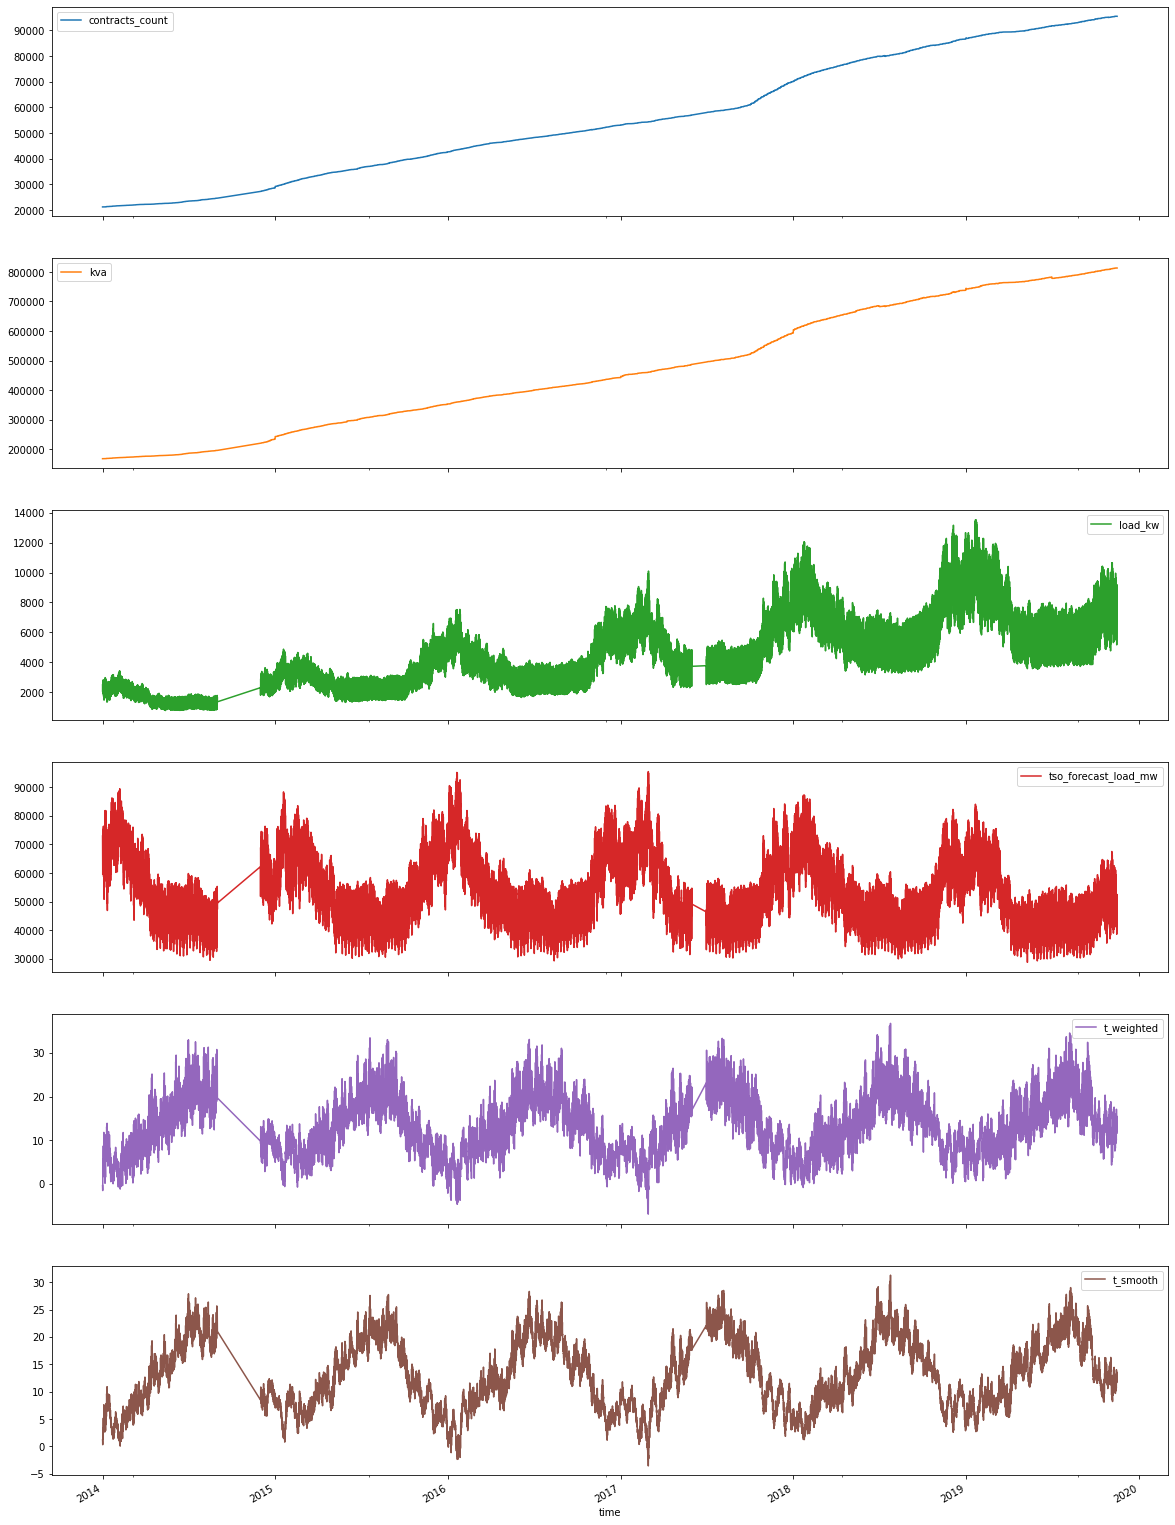

In [15]:
# Show full data set
historic.plot(figsize=(20, 30), subplots=True)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

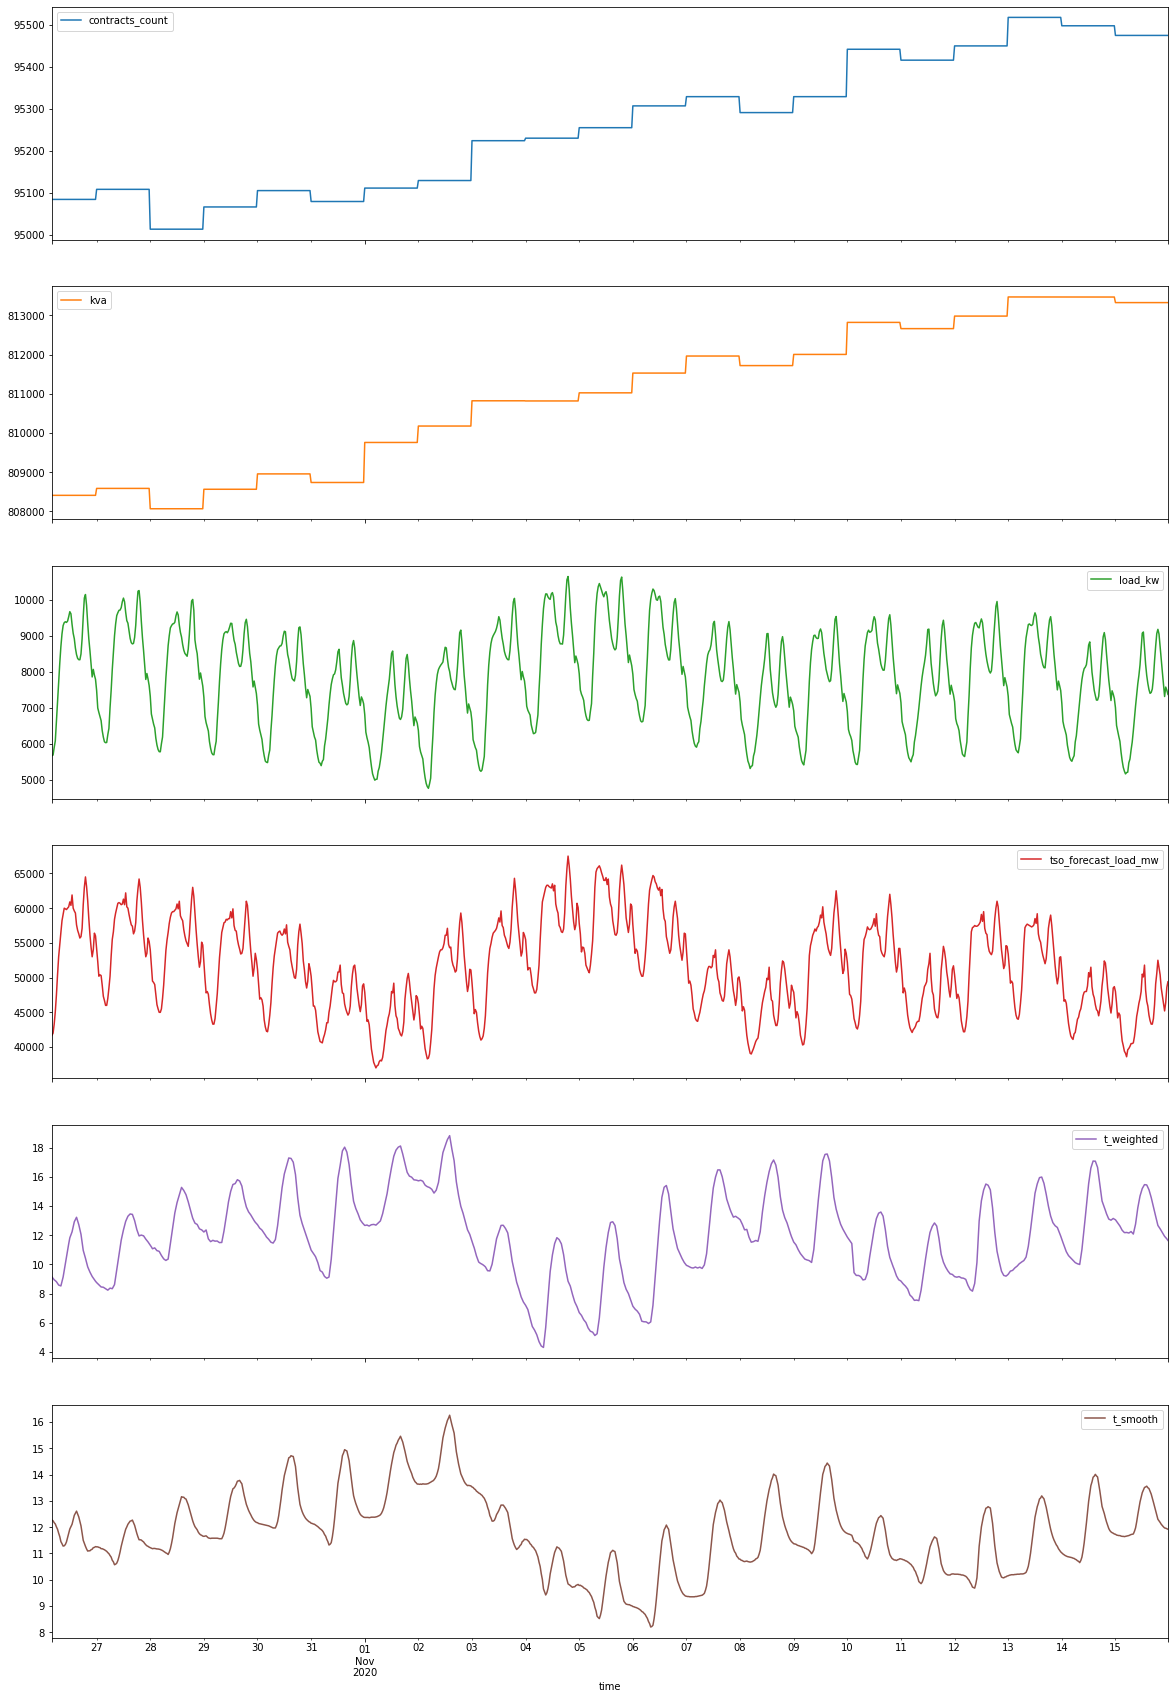

In [16]:
# Show recent data 
historic[-1000:].plot(figsize=(20, 30), subplots=True)

Don't hesitate to add your own visualisations!

## 3. Feature engineering

Before we train, we will add some features based on the `datetime`, and some calendar features related to national holidays or school holydays.

We use some packages for the holidays, which are used in **enda.feature_engineering.calendar**  : 
```bash
pip install jours-feries-france vacances-scolaires-france Unidecode
```


In [17]:
import enda.feature_engineering.calendar

In [18]:
# define the features we want to add before training/predicting
def featurize(df):
    # put datetime features to capture the data frequencies: daily, weekly and yearly periods.  
    df = enda.DatetimeFeature.split_datetime(
        df, split_list = ['minuteofday', 'dayofweek', 'month']
    )
    df = enda.DatetimeFeature.encode_cyclic_datetime_index(
        df, split_list = ['minuteofday', 'dayofweek', 'dayofyear']
    )
    
    # add features about national holidays and school holidays (French holidays here)
    special_days = enda.feature_engineering.calendar.Calendar().get_french_special_days() 
    df = pd.merge(
        df, special_days,
        how='left', left_index=True, right_index=True
    )
    return df
    

In [19]:
full_train_set = featurize(historic)

In [20]:
full_train_set

,contracts_count,kva,load_kw,tso_forecast_load_mw,t_weighted,t_smooth,minuteofday,dayofweek,month,minuteofday_cos,minuteofday_sin,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,lockdown,public_holiday,nb_school_areas_off,extra_long_weekend
time,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,21261.0,167416.4,2490.925806,72900.0,-0.41,1.17,0,3,1,1.000000,0.000000,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 00:30:00+01:00,21261.0,167416.4,2412.623113,71600.0,-0.48,1.17,30,3,1,0.991445,0.130526,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 01:00:00+01:00,21261.0,167416.4,2365.611276,69900.0,-0.55,1.15,60,3,1,0.965926,0.258819,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 01:30:00+01:00,21261.0,167416.4,2336.141065,70600.0,-0.66,1.14,90,3,1,0.923880,0.382683,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 02:00:00+01:00,21261.0,167416.4,2300.935642,70500.0,-0.78,1.11,120,3,1,0.866025,0.500000,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,95475.0,813328.8,7657.293444,46200.0,12.05,12.01,1290,6,11,0.793353,-0.608761,0.623490,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:00:00+01:00,95475.0,813328.8,7317.540759,45200.0,11.92,11.97,1320,6,11,0.866025,-0.500000,0.623490,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:30:00+01:00,95475.0,813328.8,7580.051439,46400.0,11.84,11.96,1350,6,11,0.923880,-0.382683,0.623490,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0


In [21]:
# train a basic SKLearnLinearRegression
from enda.ml_backends.sklearn_estimator import SklearnEstimator
from sklearn.linear_model import LinearRegression

lin_reg = SklearnEstimator(LinearRegression())
lin_reg.train(full_train_set, target_col='load_kw')

## 4. Portfolio forecast & basic prediction

We need an estimate of our portfolio in the next few days, the tso_load and weather forecasts. 

In order to get our portfolio in the next few days, here we will just consider the latest trends in our portfolio. 

In another setup, you might want to connect to your sales software or ERP and take into account contracts that will end or start soon.

We will use `enda.Contracts.forecast_using_trend`which requires the `statsmodel` package : 
```bash
pip install statsmodels
```

In [22]:
# we will forecast the portfolio using holt method 
forecast_portfolio =  enda.Contracts.forecast_using_trend(
    portfolio_df=portfolio,
    start_forecast_date=pd.to_datetime("2020-12-01 00:00:00+01:00"),
    nb_days=7,  
    past_days=150  # only use recent portfolio trend to forecast the next few days
)
forecast_portfolio

/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


,contracts_count,kva
time,,
2020-12-01 00:00:00+01:00,96134.6,820008.8
2020-12-01 00:30:00+01:00,96135.3,820011.8
2020-12-01 01:00:00+01:00,96135.9,820014.9
2020-12-01 01:30:00+01:00,96136.5,820017.9
2020-12-01 02:00:00+01:00,96137.1,820021.0
...,...,...
2020-12-07 21:30:00+01:00,96341.2,821020.6
2020-12-07 22:00:00+01:00,96341.8,821023.7
2020-12-07 22:30:00+01:00,96342.4,821026.7


In [23]:
# add weather_and_tso_forecasts
forecast_input_data = pd.merge(
    forecast_portfolio, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)
# add feature engineering
forecast_input_data = featurize(forecast_input_data)
forecast_input_data

,contracts_count,kva,tso_forecast_load_mw,t_weighted,t_smooth,minuteofday,dayofweek,month,minuteofday_cos,minuteofday_sin,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,lockdown,public_holiday,nb_school_areas_off,extra_long_weekend
time,,,,,,,,,,,,,,,,,,
2020-12-01 00:00:00+01:00,96134.6,820008.8,66100.0,4.69,5.08,0,1,12,1.000000,0.000000,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 00:30:00+01:00,96135.3,820011.8,64200.0,4.82,5.10,30,1,12,0.991445,0.130526,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 01:00:00+01:00,96135.9,820014.9,61900.0,4.96,5.12,60,1,12,0.965926,0.258819,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 01:30:00+01:00,96136.5,820017.9,62800.0,5.04,5.13,90,1,12,0.923880,0.382683,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 02:00:00+01:00,96137.1,820021.0,62300.0,5.13,5.14,120,1,12,0.866025,0.500000,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 21:30:00+01:00,96341.2,821020.6,68400.0,4.20,4.13,1290,0,12,0.793353,-0.608761,1.00000,0.000000,0.909308,-0.416125,0.0,0.0,0.0,0.0
2020-12-07 22:00:00+01:00,96341.8,821023.7,66900.0,4.12,4.10,1320,0,12,0.866025,-0.500000,1.00000,0.000000,0.909308,-0.416125,0.0,0.0,0.0,0.0
2020-12-07 22:30:00+01:00,96342.4,821026.7,67600.0,4.03,4.08,1350,0,12,0.923880,-0.382683,1.00000,0.000000,0.909308,-0.416125,0.0,0.0,0.0,0.0


In [24]:
# do the prediction
lin_reg_prediction = lin_reg.predict(forecast_input_data, target_col="load_kw")


<AxesSubplot:xlabel='time'>

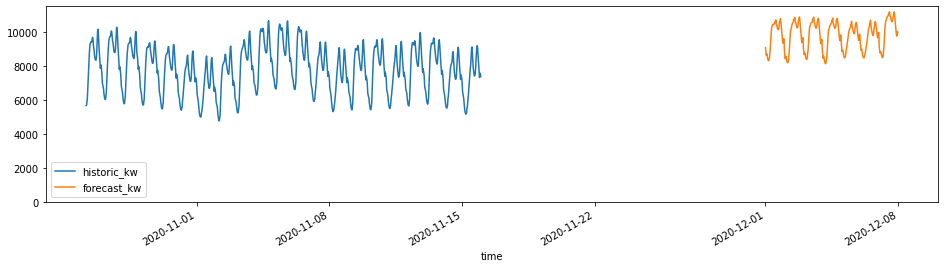

In [25]:
# visualize recent load along with our forecast; remember we don't have recent actual load so there is a time-gap. 
to_plot = pd.merge(
    historic["load_kw"][-1000:].to_frame("historic_kw"), 
    lin_reg_prediction.rename(columns={"load_kw": "forecast_kw"}), 
    how='outer', left_index=True, right_index=True
)
to_plot.plot(ylim=0, figsize=(16, 4))     

## 5. Benchmark with simple evaluation

The previous forecast based on linear regression is very limited. Let's try and use a better algorithm ! 

We will define some algorithms using `scikit-klearn` as a machine learning backend and others using `h2o`.

For that we need the `h2o` package:
```bash
pip install h2o
```



In [26]:
# here we do a benchmark, we want to compare with actual data, 
# lets say from 2020-11-01 to 2020-11-15
benchmark_train = full_train_set[full_train_set.index < '2020-11-01']
benchmark_test = full_train_set[full_train_set.index >= '2020-11-01']

benchmark = benchmark_test["load_kw"].to_frame("actual_load_kw")

benchmark_test = benchmark_test.drop(columns=["load_kw"])

In [27]:
# some parts give ConvergenceWarnings here and we'll ignore them. 
import warnings
warnings.filterwarnings('ignore')

In [28]:
# use the same method as before to predict a portfolio for 2020-11-01 -> 2020-11-15
benchmark_test_portfolio = enda.Contracts.forecast_using_trend(
    portfolio_df=portfolio[portfolio.index < '2020-11-01'],
    start_forecast_date=pd.to_datetime("2020-11-01 00:00:00+01:00"),
    nb_days=15,  
    past_days=150  # only use recent portfolio trend to forecast the next few days
)
benchmark_test['kva'] = benchmark_test_portfolio['kva']
benchmark_test['contracts_count'] = benchmark_test_portfolio['contracts_count']
benchmark_test

,contracts_count,kva,tso_forecast_load_mw,t_weighted,t_smooth,minuteofday,dayofweek,month,minuteofday_cos,minuteofday_sin,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,lockdown,public_holiday,nb_school_areas_off,extra_long_weekend
time,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00+01:00,95079.6,808742.3,47900.0,12.67,12.37,0,6,11,1.000000,0.000000,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 00:30:00+01:00,95080.2,808744.8,45800.0,12.68,12.37,30,6,11,0.991445,0.130526,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 01:00:00+01:00,95080.8,808747.2,43700.0,12.70,12.37,60,6,11,0.965926,0.258819,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 01:30:00+01:00,95081.4,808749.7,43900.0,12.66,12.37,90,6,11,0.923880,0.382683,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 02:00:00+01:00,95081.9,808752.2,43200.0,12.63,12.36,120,6,11,0.866025,0.500000,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,95500.0,810510.5,46200.0,12.05,12.01,1290,6,11,0.793353,-0.608761,0.62349,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:00:00+01:00,95500.6,810512.9,45200.0,11.92,11.97,1320,6,11,0.866025,-0.500000,0.62349,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:30:00+01:00,95501.2,810515.4,46400.0,11.84,11.96,1350,6,11,0.923880,-0.382683,0.62349,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0


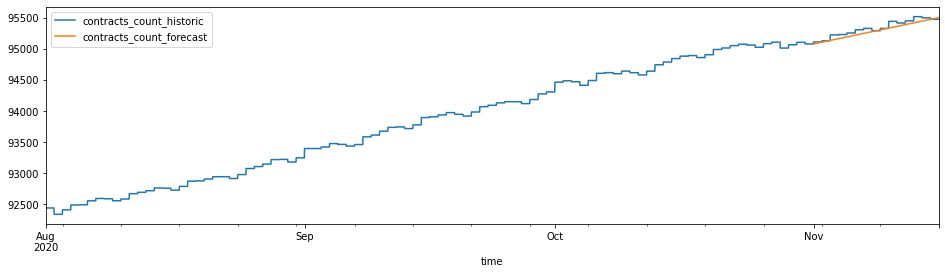

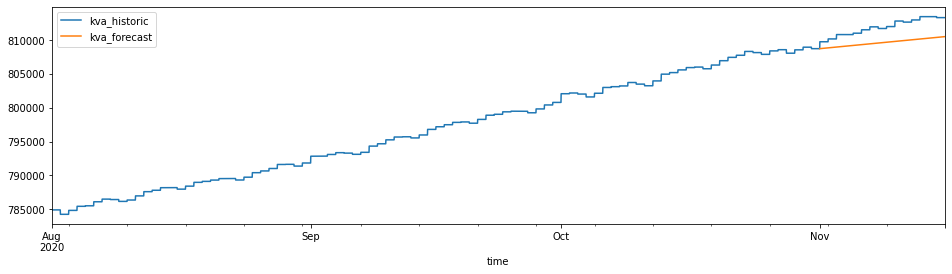

In [29]:
# compare portfolio forecast to reality
for c in ["contracts_count", "kva"]:
    to_plot = pd.merge(
        portfolio[(portfolio.index >= '2020-08-01') & (portfolio.index < '2020-11-16')][c].to_frame(c+"_historic"),
        benchmark_test[c].to_frame(c+"_forecast"),
        how='outer', left_index=True, right_index=True
    ) 
    
    to_plot.plot(figsize=(16, 4)) 

In [30]:
# Lets define some algorithms then train and predict with them
# All the models we define implement the enda.models.ModelInterface (see the docs)
# Enda comes with wrappers around scikit-learn and H2O models:
#  sklearn: enda.ml_backends.sklearn_estimator.SklearnEstimator
#  H2O: enda.ml_backends.h2o_estimator.H2OEstimator

import time
import h2o
import random
import numpy

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from enda.ml_backends.h2o_estimator import H2OEstimator  # enda's wrapper around H2O models
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2ODeepLearningEstimator

In [31]:
random.seed(17)  # set random seed for reproducibility
numpy.random.seed(17) # for sklearn 
# for h2o we will define it in each model

In [32]:
all_models = dict()

In [33]:
# Some models with the sklearn machine learning backend

all_models['sklearn_lin_reg'] = SklearnEstimator(LinearRegression())  

all_models['sklearn_sgd'] = SklearnEstimator(
    Pipeline([('standard_scaler', StandardScaler()),
              ('sgd', SGDRegressor())
             ]
            )
) 

all_models['sklearn_ada_boost'] = SklearnEstimator(AdaBoostRegressor(
    n_estimators=500,
    loss='linear', # 'square'
    learning_rate=0.8)
)  

all_models['sklearn_nn'] = SklearnEstimator(
    Pipeline([('standard_scaler', StandardScaler()),
              ('mlp', MLPRegressor(
                  solver='adam', 
                  activation='relu',
                  hidden_layer_sizes=[48, 48, 24],
                  max_iter=150
              ))
             ]
            )
)

In [34]:
# Some models with the h2o machine learning backend

all_models['h2o_glm'] = H2OEstimator(H2OGeneralizedLinearEstimator(
    standardize=False, 
    intercept=True,
    seed=17)
)

all_models['h2o_rf'] = H2OEstimator(H2ORandomForestEstimator(
    ntrees=300,
    max_depth=15,
    sample_rate=0.8,
    min_rows=10,
    nbins=52,
    mtries=3,
    seed=17
))

all_models['h2o_gbm'] = H2OEstimator(H2OGradientBoostingEstimator(
    ntrees=500,
    max_depth=5,
    sample_rate=0.5,
    min_rows=5,
    seed=17
))

all_models['h2o_xgboost'] = H2OEstimator(H2OXGBoostEstimator(
    **{
        "ntrees": 500,
        "max_depth": 5,
        "sample_rate": 0.8,
        "min_rows": 10,
        "seed": 17
    }
))

all_models['h2o_nn'] = H2OEstimator(H2ODeepLearningEstimator(
    **{
        "activation": "Tanh",
        "hidden": [48, 48, 24],
        "distribution": "gaussian",
        "epochs": 20,
        "seed": 17
    }
))

In [35]:
# You can add more models to the benchmark here if you like


In [36]:
# to train or predict with H2O models, we boot up a local h2o server
h2o.init(nthreads=-1)
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5x/409ks2012xxch_pmbs6qpzfh0000gp/T/tmpx3_pia1b
  JVM stdout: /var/folders/5x/409ks2012xxch_pmbs6qpzfh0000gp/T/tmpx3_pia1b/h2o_emmanuel_charon_started_from_python.out
  JVM stderr: /var/folders/5x/409ks2012xxch_pmbs6qpzfh0000gp/T/tmpx3_pia1b/h2o_emmanuel_charon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_emmanuel_charon_xqjnib
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [37]:
# this should take between 5 and 15 minutes to run (in function of your hardware)
print("Benchmark with {} models : {}\n".format(len(all_models), list(all_models.keys())))
for model_name, model in all_models.items():
    model_start_time = time.time()
    print("Training {} before predicting with it..".format(model_name))
    model.train(benchmark_train, target_col='load_kw')
    model_prediction = model.predict(benchmark_test, target_col='load_kw')
    benchmark[model_name] = model_prediction
    print("{} took {:.1f} seconds.\n".format(model_name, time.time()-model_start_time))


Benchmark with 9 models : ['sklearn_lin_reg', 'sklearn_sgd', 'sklearn_ada_boost', 'sklearn_nn', 'h2o_glm', 'h2o_rf', 'h2o_gbm', 'h2o_xgboost', 'h2o_nn']

Training sklearn_lin_reg before predicting with it..
sklearn_lin_reg took 0.1 seconds.

Training sklearn_sgd before predicting with it..
sklearn_sgd took 1.3 seconds.

Training sklearn_ada_boost before predicting with it..
sklearn_ada_boost took 62.1 seconds.

Training sklearn_nn before predicting with it..
sklearn_nn took 59.4 seconds.

Training h2o_glm before predicting with it..
h2o_glm took 5.4 seconds.

Training h2o_rf before predicting with it..
h2o_rf took 33.2 seconds.

Training h2o_gbm before predicting with it..
h2o_gbm took 22.7 seconds.

Training h2o_xgboost before predicting with it..
h2o_xgboost took 64.1 seconds.

Training h2o_nn before predicting with it..
h2o_nn took 80.2 seconds.



In [38]:
benchmark

,actual_load_kw,sklearn_lin_reg,sklearn_sgd,sklearn_ada_boost,sklearn_nn,h2o_glm,h2o_rf,h2o_gbm,h2o_xgboost,h2o_nn
time,,,,,,,,,,
2020-11-01 00:00:00+01:00,6817.332090,7416.477529,7542.312564,6822.188092,7351.172908,7402.432609,6537.198906,7010.410149,7032.040527,7400.976455
2020-11-01 00:30:00+01:00,6326.667322,7192.916989,7319.436451,6414.531562,7008.480631,7164.175176,6228.407756,6408.337175,6492.153809,6841.493779
2020-11-01 01:00:00+01:00,6172.223671,6974.931684,7102.126243,6260.174000,6668.162284,6925.916729,6058.203420,6207.136015,6351.727051,6353.977698
2020-11-01 01:30:00+01:00,6050.575318,6993.462928,7122.302861,6260.174000,6546.138912,6948.635651,6019.727900,6059.606349,6259.075684,6178.509022
2020-11-01 02:00:00+01:00,5898.881230,6928.525322,7058.529345,6162.218857,6329.058216,6869.233390,5838.660528,5967.455171,6184.107422,5974.518119
...,...,...,...,...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,7657.293444,7554.874780,7696.545257,7679.641519,8075.749892,7227.449423,7483.921108,7272.697440,7436.578125,8017.731406
2020-11-15 22:00:00+01:00,7317.540759,7422.568321,7565.035767,7632.927837,7831.622914,7114.005755,7369.696343,7050.622522,7187.884766,7788.172288
2020-11-15 22:30:00+01:00,7580.051439,7510.802466,7655.102382,7726.430994,7792.580825,7250.192657,7411.223903,7247.823333,7486.856934,7715.353810


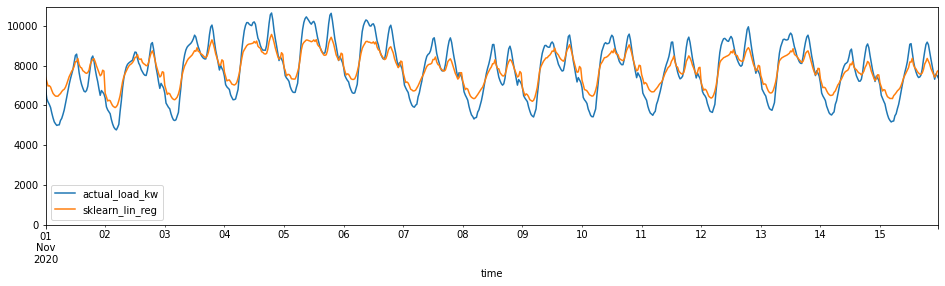

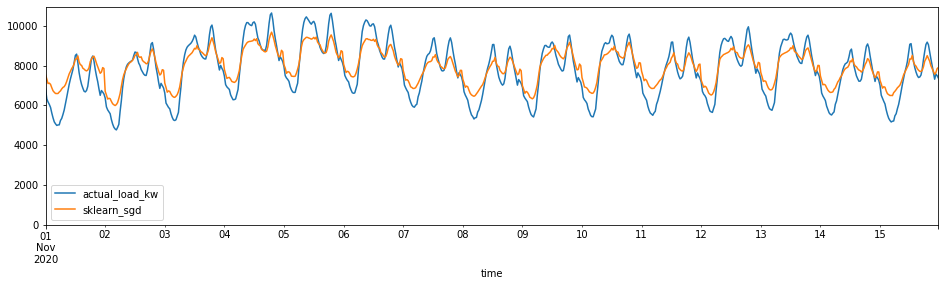

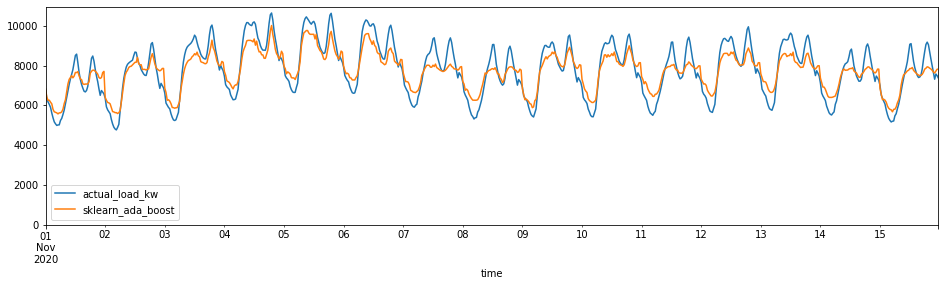

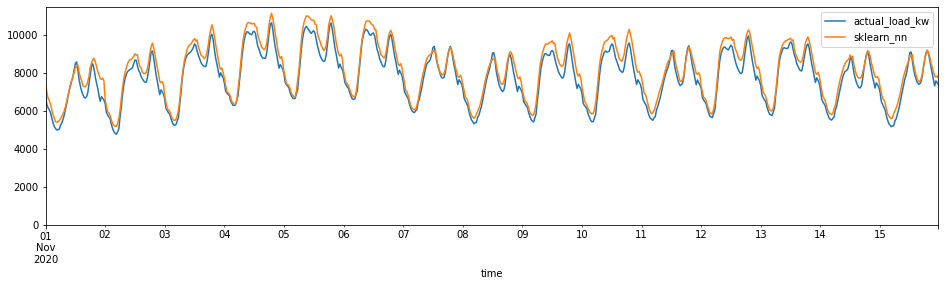

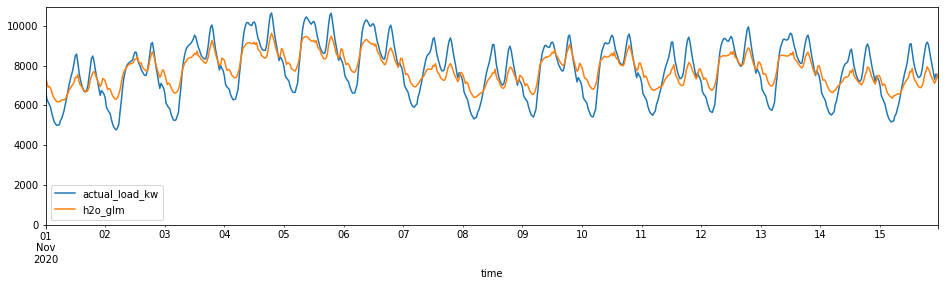

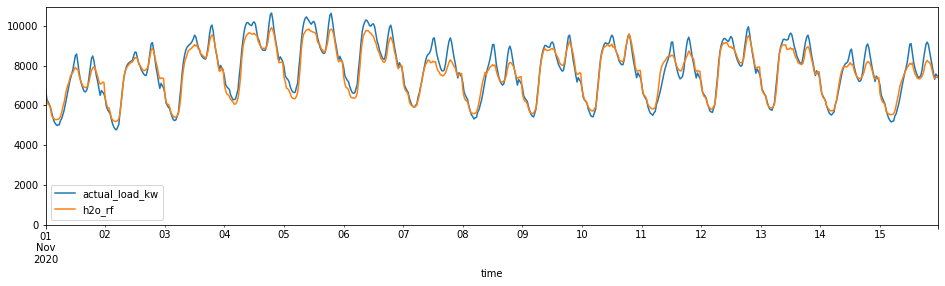

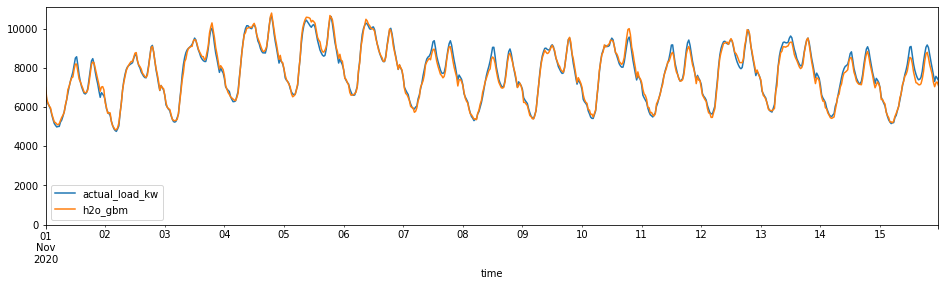

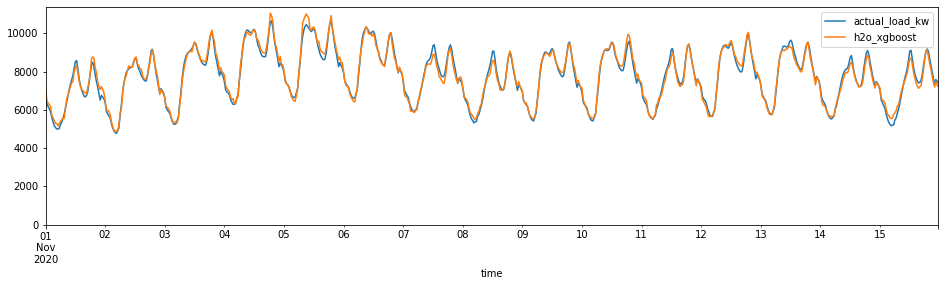

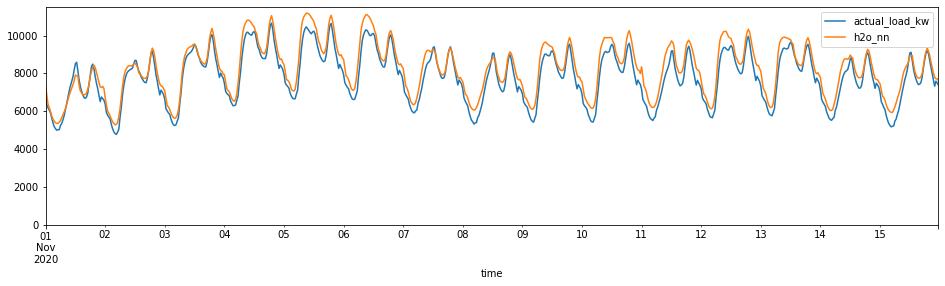

In [39]:
# visualize predictions
for c in benchmark.columns:
    if c != "actual_load_kw":
        to_plot = benchmark[["actual_load_kw", c]]
        to_plot.plot(ylim=0, figsize=(16, 4)) 

In [40]:
# compute the mean absolute percentage error
benchmark_ape = benchmark.copy(deep=True).drop(columns=["actual_load_kw"])
for c in benchmark_ape.columns:
    benchmark_ape[c] = (benchmark_ape[c] - benchmark["actual_load_kw"]).abs()/benchmark["actual_load_kw"]*100
benchmark_ape.mean().to_frame("mape")

,mape
sklearn_lin_reg,7.055730
sklearn_sgd,7.513167
sklearn_ada_boost,6.347616
sklearn_nn,5.091200
h2o_glm,9.057864
h2o_rf,3.424008
h2o_gbm,1.721648
h2o_xgboost,1.995853
h2o_nn,6.338839


## 6. Benchmark with Backtesting

In traditional machine learning, we need more than just 1 evaluation to test an algorithm. We typically use cross-validation to see if the algorithm is not biased and if it can be expected to work well in most cases. For time-series predictions we cannot do a regular cross-validation because it is not realistic : we always want to train using historical data that happened before the prediction. 

Here we will do **backtesting** week after week. With the given dataset, this means :
- for each week w from early 2019 until the end of the dataset : train using data from the beginning of the dataset (early 2015) until a few days before week w, then eval on w. 
    - the first iteration will train an algorithm using data from 2015 to 2018, then eval on the first week of 2019
    - the second iteration will train using data from 2015 to a bit before the first week of 2019, then eval on the second week of 2019
    - and so on...
- keep the predictions of each time-step using this method, from early 2019 to november 2020.  
- then compare these predictions to the historic data to evaluate the quality of each algorithm. 

This makes most sense if in your production environment, you plan to retrain the algorithm regularly with recent data. 


Backtesting can take a significant amount of time. 
We backtest only 2 linear regressions below in order to have an example that runs fast. Don't hesitate to add other algorithms. 

In [41]:
all_models = dict()

all_models['sklearn_lin_reg'] = SklearnEstimator(LinearRegression())

all_models['h2o_glm'] = H2OEstimator(H2OGeneralizedLinearEstimator(standardize=False, intercept=True))

In [42]:
start_backtesting_dt = pd.to_datetime('2019-01-01 00:00:00+01:00').tz_convert('Europe/Paris')
benchmark = historic[historic.index>=start_backtesting_dt]["load_kw"].to_frame("actual_load_kw")
days_in_each_iteration = 28


for model_name, model in all_models.items():

    count_iterations = 0
    
    model_predictions = []

    for train_set, test_set in enda.BackTesting.yield_train_test(
        historic,
        start_eval_datetime=start_backtesting_dt,
        days_between_trains=days_in_each_iteration,
        gap_days_between_train_and_eval=14
    ):
        count_iterations += 1
        if count_iterations <= 2 or count_iterations % 10 == 0:
            print("Model {}, backtesting iteration {}, train set {}->{}, test set {}->{}\n".format(
                   model_name, count_iterations, 
                   train_set.index.min(), train_set.index.max(), 
                   test_set.index.min(), test_set.index.max()))
        
        # featurize
        train_set = featurize(train_set)
        test_set = test_set.drop(columns=["load_kw"])
        test_set = featurize(test_set)
        
        # use forecast porfolio in test_set
        forecast_portfolio = enda.Contracts.forecast_using_trend(
            portfolio_df=portfolio[portfolio.index<test_set.index.min()],
            start_forecast_date=test_set.index.min(),
            nb_days=days_in_each_iteration,  
            past_days=150)  # recent portfolio trend
        
        test_set['kva'] = forecast_portfolio['kva']
        test_set['contracts_count'] = forecast_portfolio['contracts_count']

        # train and predict
        model.train(train_set, target_col='load_kw')
        model_predictions.append(model.predict(test_set, target_col='load_kw'))
    
    benchmark[model_name] = pd.concat(model_predictions)


Model sklearn_lin_reg, backtesting iteration 1, train set 2015-01-01 00:00:00+01:00->2018-12-17 23:30:00+01:00, test set 2019-01-01 00:00:00+01:00->2019-01-28 23:30:00+01:00

Model sklearn_lin_reg, backtesting iteration 2, train set 2015-01-01 00:00:00+01:00->2019-01-14 23:30:00+01:00, test set 2019-01-29 00:00:00+01:00->2019-02-25 23:30:00+01:00

Model sklearn_lin_reg, backtesting iteration 10, train set 2015-01-01 00:00:00+01:00->2019-08-26 23:30:00+02:00, test set 2019-09-10 00:00:00+02:00->2019-10-07 23:30:00+02:00

Model sklearn_lin_reg, backtesting iteration 20, train set 2015-01-01 00:00:00+01:00->2020-06-01 23:30:00+02:00, test set 2020-06-16 00:00:00+02:00->2020-07-13 23:30:00+02:00

Model h2o_glm, backtesting iteration 1, train set 2015-01-01 00:00:00+01:00->2018-12-17 23:30:00+01:00, test set 2019-01-01 00:00:00+01:00->2019-01-28 23:30:00+01:00

Model h2o_glm, backtesting iteration 2, train set 2015-01-01 00:00:00+01:00->2019-01-14 23:30:00+01:00, test set 2019-01-29 00:00:0

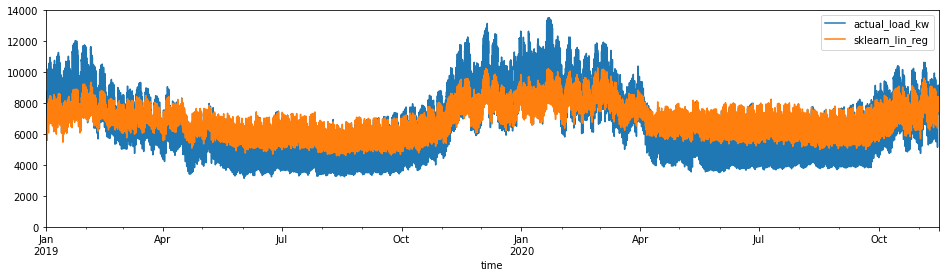

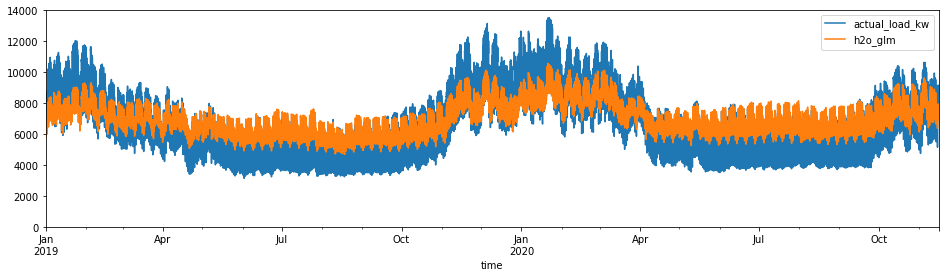

In [43]:
# visualize predictions
for c in benchmark.columns:
    if c != "actual_load_kw":
        to_plot = benchmark[["actual_load_kw", c]]
        to_plot.plot(ylim=0, figsize=(16, 4)) 

In [44]:
# compute absolute percentage error
benchmark_ape = benchmark.copy(deep=True).drop(columns=["actual_load_kw"])
for c in benchmark_ape.columns:
    benchmark_ape[c] = (benchmark_ape[c] - benchmark["actual_load_kw"]).abs()/benchmark["actual_load_kw"]*100
benchmark_ape.mean().to_frame("mape")

,mape
sklearn_lin_reg,13.164438
h2o_glm,14.279924


If you have time/computing power: 
- try more algorithms in the backtesting benchmark, this is longer but more reliable than a simple benchmark (think of it as crossval versus single eval in a non-time-series setup).
- reduce the "days_in_each_iteration" down to 7 if you think you can have a weekly training in your production environment. 

## 7. Make the prediction

Seeing the results from just the basic benchmark, we here decide to predict using h2o's gbm. We now need to train it on the full dataset and make the prediction. 

In [45]:
gbm = H2OEstimator(H2OGradientBoostingEstimator(
    ntrees=500,
    max_depth=5,
    sample_rate=0.5,
    min_rows=5
))

In [46]:
gbm.train(full_train_set, target_col='load_kw')

In [47]:
gbm_prediction = gbm.predict(forecast_input_data, target_col="load_kw")

<AxesSubplot:xlabel='time'>

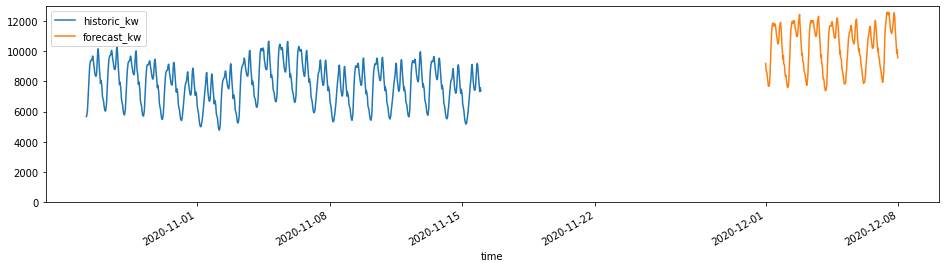

In [48]:
# visualize recent load along with our forecast; remember we don't have recent actual load so there is a time-gap. 
# (remember that the prediction takes weather forecast and more information into account)
to_plot = pd.merge(
    historic["load_kw"][-1000:].to_frame("historic_kw"), 
    gbm_prediction.rename(columns={"load_kw": "forecast_kw"}), 
    how='outer', left_index=True, right_index=True
)
to_plot.plot(ylim=0, figsize=(16, 4))     

In [49]:
# don't forget to shutdown your h2o local server
h2o.cluster().shutdown()
# wait for h2o to really finish shutting down
time.sleep(5)  

H2O session _sid_88cb closed.


## Conclusion

Thats all for Example B. Check out Example C next. Thanks for reading and don't hesitate to send feeback at: emmanuel.charon@enercoop.org !